In [1]:
import sys
import numpy
import argparse
from dataset import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Input,Dense,Dropout
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import matplotlib.cm as colormap
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(numpy.linspace(0, 1, len(history))))
    for i in xrange(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

In [3]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(numpy.linspace(0, 1, len(history))))
    for i in xrange(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

In [4]:
dataset = 'vgg16-cg.pkl'

In [5]:
ds = Dataset()
X, y, list_fams, no_imgs = ds.load(dataset)

In [6]:
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [7]:
# Create stratified k-fold subsets
kfold = 10  # no. of folds
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0
for index in skf.split(X, y):
    skfind[cnt] = index
    cnt += 1
    
history = []
conf_mat = numpy.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='cg-weights-min_loss-mlp-vgg16-2layers-160neurons-relu-0.5dropout-Adam-200epochs.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    clf = Sequential()
    clf.add(Dense(160, input_shape=(X_train.shape[1],), activation='relu', name='fc1'))
    clf.add(Dropout(0.5))
    clf.add(Dense(160, activation='relu', name='fc2'))
    clf.add(Dropout(0.5))
    clf.add(Dense(Y_train.shape[1], activation='softmax', name='predictions'))
    clf.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    h = clf.fit(X_train, Y_train, validation_data=(X_test, Y_test), nb_epoch=200, batch_size=X_train.shape[0], verbose=1, callbacks=[checkpointer])  # Training
    history.append(h)
    
    y_predict = clf.predict_classes(X_test, verbose=0)  # Testing
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_predict)))
    cm = confusion_matrix(y_test,y_predict)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

/usr/local/lib/python2.7/dist-packages/keras/models.py:834: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 14755 samples, validate on 1641 samples
Epoch 1/200
14755/14755 [==============================] - 3s - loss: 0.9153 - acc: 0.4924 - val_loss: 0.7055 - val_acc: 0.5040
Epoch 2/200
14755/14755 [==============================] - 2s - loss: 1.2902 - acc: 0.5276 - val_loss: 1.6320 - val_acc: 0.5119
Epoch 3/200
14755/14755 [==============================] - 2s - loss: 1.5572 - acc: 0.5378 - val_loss: 0.6402 - val_acc: 0.6356
Epoch 4/200
14755/14755 [==============================] - 2s - loss: 1.0743 - acc: 0.5695 - val_loss: 0.7306 - val_acc: 0.5746
Epoch 5/200
14755/14755 [==============================] - 2s - loss: 0.9720 - acc: 0.5815 - val_loss: 0.6316 - val_acc: 0.6015
Epoch 6/200
14755/14755 [==============================] - 2s - loss: 0.8024 - acc: 0.5959 - val_loss: 0.5496 - val_acc: 0.7569
Epoch 7/200
14755/14755 [==============================] - 2s - loss: 0.6534 - acc: 0.6320 - val_loss: 0.5483 - val_acc: 0.7258
Epoch 8/200
14755/14755 [==============================

14755/14755 [==============================] - 2s - loss: 0.0659 - acc: 0.9804 - val_loss: 0.3443 - val_acc: 0.9080
Epoch 128/200
14755/14755 [==============================] - 3s - loss: 0.0641 - acc: 0.9820 - val_loss: 0.3510 - val_acc: 0.9086
Epoch 129/200
14755/14755 [==============================] - 2s - loss: 0.0624 - acc: 0.9823 - val_loss: 0.3624 - val_acc: 0.9043
Epoch 130/200
14755/14755 [==============================] - 2s - loss: 0.0633 - acc: 0.9814 - val_loss: 0.3486 - val_acc: 0.9080
Epoch 131/200
14755/14755 [==============================] - 3s - loss: 0.0618 - acc: 0.9831 - val_loss: 0.3540 - val_acc: 0.9043
Epoch 132/200
14755/14755 [==============================] - 2s - loss: 0.0621 - acc: 0.9820 - val_loss: 0.3536 - val_acc: 0.9062
Epoch 133/200
14755/14755 [==============================] - 2s - loss: 0.0620 - acc: 0.9823 - val_loss: 0.3560 - val_acc: 0.9086
Epoch 134/200
14755/14755 [==============================] - 2s - loss: 0.0607 - acc: 0.9833 - val_loss:

14755/14755 [==============================] - 3s - loss: 0.3915 - acc: 0.8422 - val_loss: 0.3263 - val_acc: 0.8702
Epoch 54/200
14755/14755 [==============================] - 2s - loss: 0.3985 - acc: 0.8424 - val_loss: 0.3242 - val_acc: 0.8708
Epoch 55/200
14755/14755 [==============================] - 3s - loss: 0.3913 - acc: 0.8472 - val_loss: 0.3206 - val_acc: 0.8732
Epoch 56/200
14755/14755 [==============================] - 2s - loss: 0.3853 - acc: 0.8544 - val_loss: 0.3156 - val_acc: 0.8745
Epoch 57/200
14755/14755 [==============================] - 2s - loss: 0.3787 - acc: 0.8516 - val_loss: 0.3117 - val_acc: 0.8714
Epoch 58/200
14755/14755 [==============================] - 3s - loss: 0.3739 - acc: 0.8534 - val_loss: 0.3104 - val_acc: 0.8745
Epoch 59/200
14755/14755 [==============================] - 2s - loss: 0.3651 - acc: 0.8622 - val_loss: 0.3091 - val_acc: 0.8775
Epoch 60/200
14755/14755 [==============================] - 2s - loss: 0.3651 - acc: 0.8569 - val_loss: 0.3047

14755/14755 [==============================] - 2s - loss: 0.1169 - acc: 0.9661 - val_loss: 0.2951 - val_acc: 0.9025
Epoch 180/200
14755/14755 [==============================] - 2s - loss: 0.1125 - acc: 0.9705 - val_loss: 0.3155 - val_acc: 0.9055
Epoch 181/200
14755/14755 [==============================] - 2s - loss: 0.1182 - acc: 0.9621 - val_loss: 0.3068 - val_acc: 0.9025
Epoch 182/200
14755/14755 [==============================] - 2s - loss: 0.1128 - acc: 0.9688 - val_loss: 0.3098 - val_acc: 0.9013
Epoch 183/200
14755/14755 [==============================] - 2s - loss: 0.1118 - acc: 0.9678 - val_loss: 0.3111 - val_acc: 0.9025
Epoch 184/200
14755/14755 [==============================] - 2s - loss: 0.1113 - acc: 0.9704 - val_loss: 0.3098 - val_acc: 0.9037
Epoch 185/200
14755/14755 [==============================] - 3s - loss: 0.1104 - acc: 0.9677 - val_loss: 0.3160 - val_acc: 0.9013
Epoch 186/200
14755/14755 [==============================] - 2s - loss: 0.1092 - acc: 0.9683 - val_loss:

KeyboardInterrupt: 

In [8]:
# Computing the average accuracy
avg_acc = numpy.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.1811


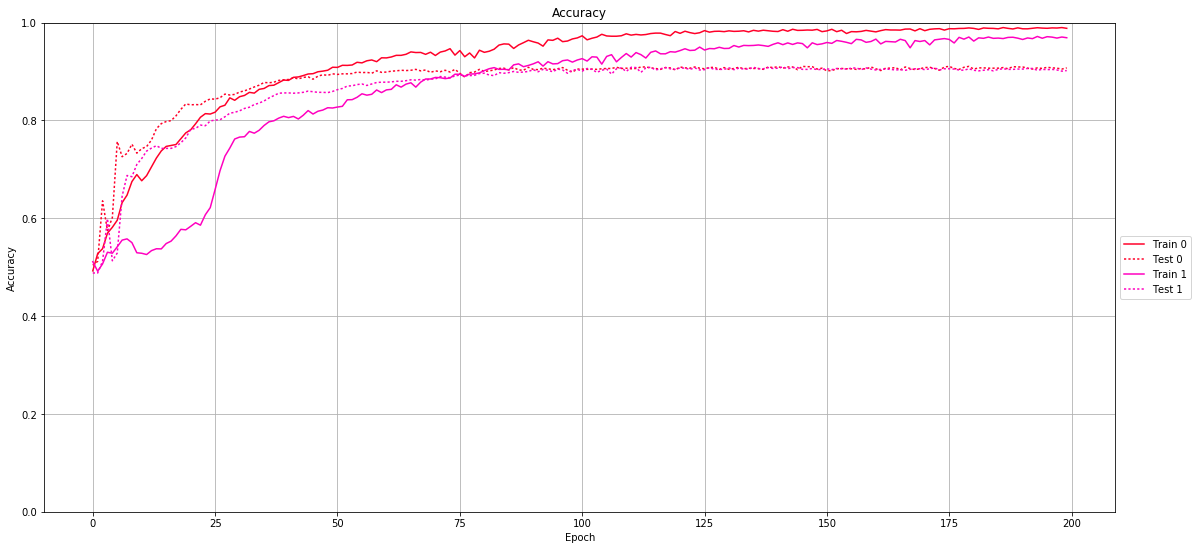

In [9]:
plot_acc(history)

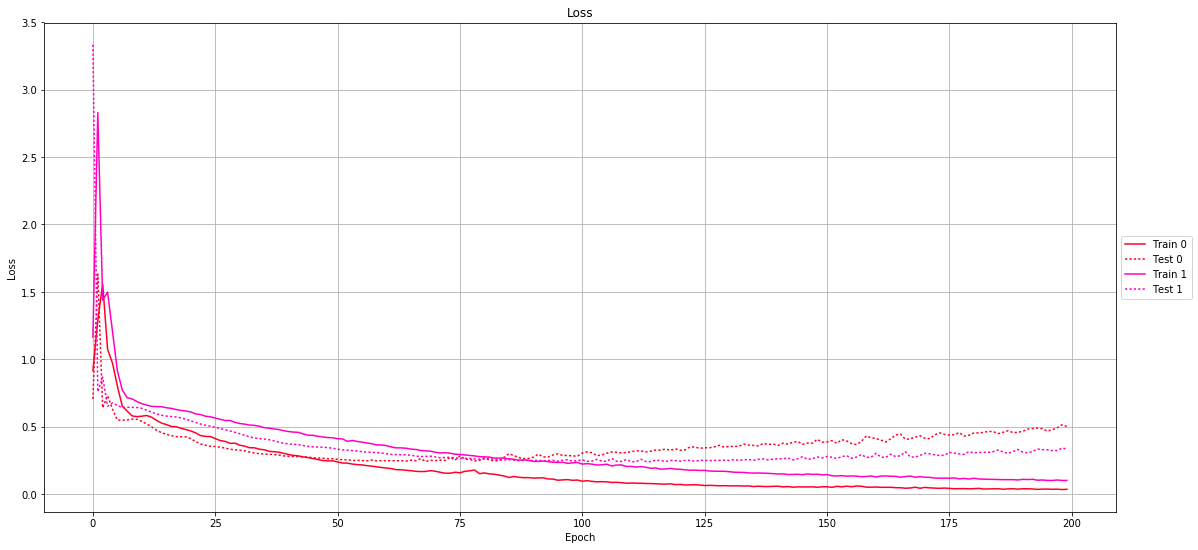

In [10]:
plot_loss(history)

In [11]:
# Viewing the confusion matrix
conf_mat = conf_mat.T  # since rows and cols are interchangeable
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix

Plotting the confusion matrix


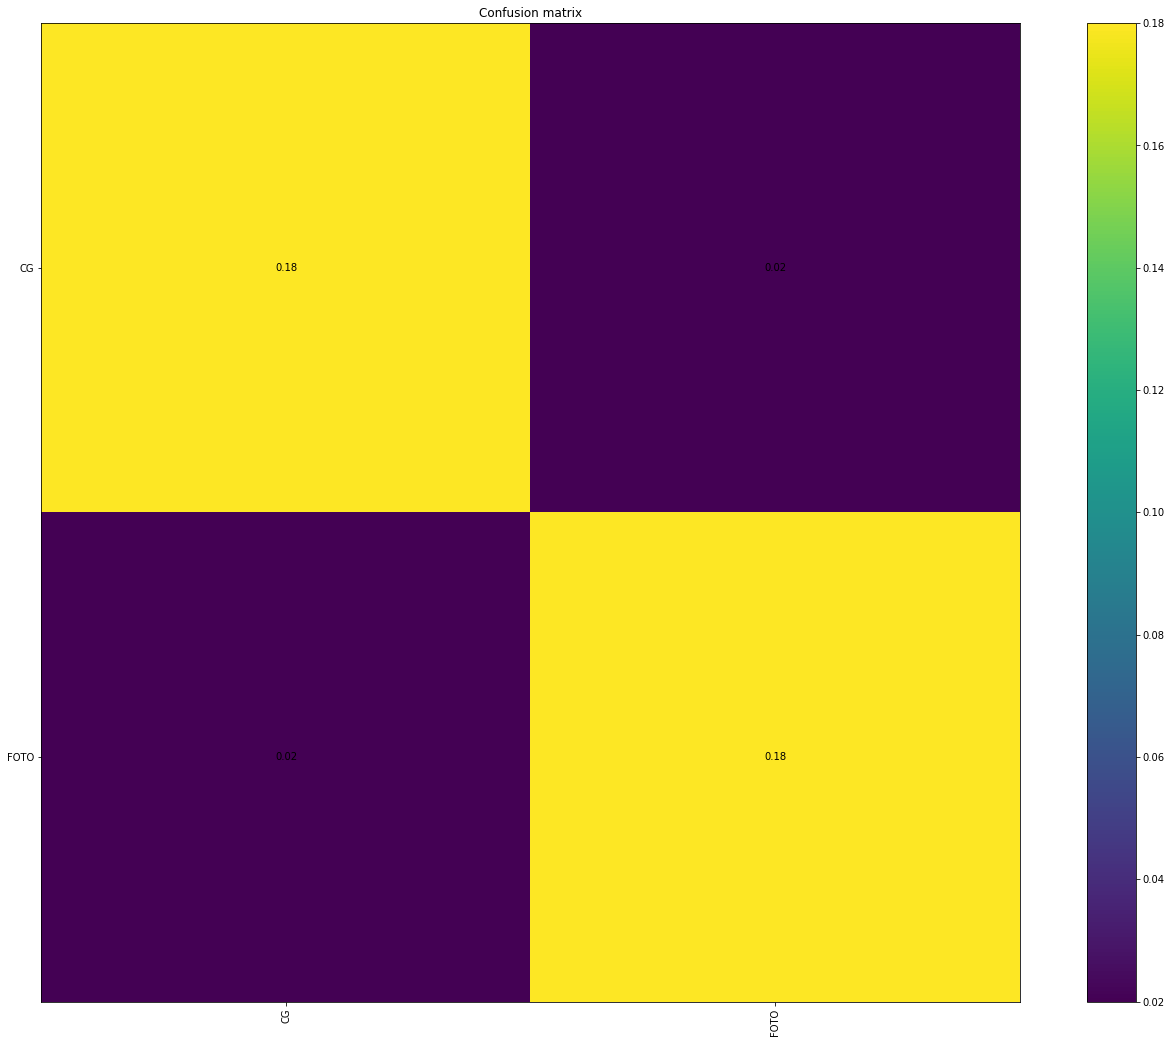

In [12]:
print("Plotting the confusion matrix")
conf_mat = numpy.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(24, 18)
plt.imshow(conf_mat,interpolation='nearest')
for row in xrange(len(list_fams)):
    for col in xrange(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.title('Confusion matrix')
plt.colorbar()
plt.show()